#### Import libraries and path to folder with datasets

In [1]:
# __________Packages__________
import pandas as pd
import collections
import random
import sys
import xgboost as xgb
import os
import time
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import make_scorer, mean_absolute_error, median_absolute_error,r2_score,explained_variance_score
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import roc_auc_score
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import scipy.stats
import scikit_posthocs as sp
import seaborn as sns
import matplotlib.pyplot as plt
import shap 

# _________Import regression models for task___________
# pip install rgf_python
# sys.path.insert(1, 'palobst')
from catboost import CatBoostRegressor
from rgf.sklearn import RGFRegressor
from optboosting.boosting import *
from palobst import *

# _______Path to folder with datasets_________
data_field='regressionDatasets'
datasets=os.listdir(data_field)

#### Preprocessing namely label encoder and NaN replacement for datasets

In [2]:
def label_encoder(df):
    cat_mask =df.dtypes == object
    cat_features=df.columns[cat_mask].tolist()
    for feature in cat_features:
        dict_map={}
        values=df[feature].unique()
        z=0
        for i in values:
            dict_map[i]=z
            z+=1
        df[feature]=df[feature].map(dict_map) 
    df=df.fillna(-999)
    return df 

#### Dicrionaries with hyper parametrs to tuning for all regressors

In [3]:
params_PaloBst={'distribution':["gaussian"], 'learning_rate':np.arange(0.01,1,0.05),
                'n_estimators':np.arange(100,500,50),'subsample':np.arange(0.1,1,0.1)}
params_RGFR={'l2':np.arange(0.01,1,0.05), 'max_leaf':range(1000,10000,200), 'learning_rate':np.arange(0.01,1,0.05)}
params_AcceleratedBoost={'descent':['proximal','gradient'], 'loss':['ls','lad'],
                    'learning_rate':np.arange(0.01,1,0.05),'n_estimators':np.arange(100,500,50)}
params_CatBoost = {'learning_rate':np.arange(0.05, 0.31, 0.05),'depth': [4, 6, 10],
                   'l2_leaf_reg': [1, 3, 5, 7, 9]}

#### Function that apply our regression models, tunes our hyper parametrs in model and return required data
#### We used RandomSearch for tuning hyper parametrs, 3 fold cv and 50 iterations for search.

In [4]:
def learning(alpha,cv=3,n_iter=50):
    mse_scorer = make_scorer(MSE,greater_is_better=False) 
    if alpha==1:
        model = PaloBst(distribution="gaussian")
        model.warmup()
        params=params_PaloBst
        name='PaloBst'
    elif alpha==2:
        model = RGFRegressor(loss="LS", normalize=True)
        params=params_RGFR
        name='RGFR'
    elif alpha==3:
        model = OptBoosting(step=100)
        params=params_AcceleratedBoost
        name='AcceleratedBoost'  
    else:
        model = CatBoostRegressor(silent=True)
        params=params_CatBoost
        name='CatBoost'  
    param={}
    if name!='CatBoost':
        RS = RandomizedSearchCV(model, params, cv=cv,n_iter=n_iter,scoring=mse_scorer)
        start_train_time=time.time()    
        RS.fit(X_train, y_train)
        training_time=time.time() - start_train_time
        for key in list(params.keys()):
            param[key]=RS.get_params()['estimator__'+key]
    else: 
        start_train_time=time.time()
        RSr = model.randomized_search(params_CatBoost, X_train, y_train, cv=cv, n_iter=n_iter, verbose=False)
        training_time=time.time() - start_train_time
        RS=model
        param=model.get_params()
    len_rows=X_test.shape[0]
#     print(len_rows)
    start_pred_time=time.time() 
    prediction=RS.predict(X_test)
    inference_time=time.time() - start_pred_time  
    inference_time_1000=(inference_time/len_rows)*1000
#     print(inference_time,inference_time_1000)
    index1=MSE(y_test,prediction) 
    index2=mean_absolute_error(y_test,prediction)
    index3=median_absolute_error(y_test,prediction)
    index4=r2_score(y_test,prediction)
    index5=explained_variance_score(y_test,prediction)
    return(name,index1,index2,index3,index4,index5,training_time,inference_time_1000,param) 

#### Now for each dataset we apply our function on 10 splits and save for each dataset csv file with results

In [5]:
for dataset in datasets:    
    dataset_name=[]
    alghotihm=[]
    cross_validation=[]
    hypermarametrs=[]
    mse_value=[]
    mean_abs_err_value=[]
    median_abs_err_value=[]
    r2_value=[]
    exp_var_score=[]
    train_time=[]
    test_time=[]  
    df=pd.read_csv(data_field+'/'+dataset)
    df=label_encoder(df)
    y=df.iloc[:,-1]
    X=df.drop(df.columns[len(df.columns)-1],axis=1)
    for split in range(1,11):        
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=random.randint(1,100))
        X_train=X_train.reset_index(drop=True).to_numpy()
        X_test=X_test.reset_index(drop=True).to_numpy()
        y_train=y_train.reset_index(drop=True).to_numpy()
        y_test=y_test.reset_index(drop=True).to_numpy()
        for model in range(1,5):
            name,index1,index2,index3,index4,index5,training_time,inference_time,param=learning(model)
            dataset_name.append(dataset)
            alghotihm.append(name)
            train_time.append(training_time)
            test_time.append(inference_time)
            mse_value.append(index1)
            mean_abs_err_value.append(index2)
            median_abs_err_value.append(index3)
            r2_value.append(index4)
            exp_var_score.append(index5)
            hypermarametrs.append(param)
            cross_validation.append(split)
    df=pd.DataFrame()
    df['Dataset name']=dataset_name
    df['Algorithm']=alghotihm 
    df['MSE']=mse_value
    df['Mean absolute error']=mse_value
    df['Median absolute error']=mse_value
    df['R2 score']=mse_value
    df['Explained variance']=mse_value
    df['Training time']=train_time
    df['Inference time']=test_time
    df['Hyper-Parameters']=hypermarametrs
    df['Cross Validation']=cross_validation
    df.to_csv('output/{}.csv'.format(dataset),index=False)

#### Now we open each csv file and load it to general dataframe

In [5]:
path_output='output/'
df_list=[]
for df in os.listdir(path_output):
    df_list.append(pd.read_csv(path_output+df))
df_final=pd.concat(df_list)
df_final.to_csv('results/table_of_results.csv',index=False)
df_final.to_excel('results/table_of_results.xlsx',index=False)
print('Datasets in dataframe:',df_final['Dataset name'].unique().shape[0])
df_final.head(5)

Datasets in dataframe: 100


Dataset name         Algorithm        MSE  Mean absolute error  \
0   Acorns.csv           PaloBst   8.137915             8.137915   
1   Acorns.csv              RGFR   8.919651             8.919651   
2   Acorns.csv  AcceleratedBoost   6.357838             6.357838   
3   Acorns.csv          CatBoost  25.655279            25.655279   
4   Acorns.csv           PaloBst   5.402222             5.402222   

   Median absolute error   R2 score  Explained variance  Training time  \
0               8.137915   8.137915            8.137915     271.529028   
1               8.919651   8.919651            8.919651       7.650091   
2               6.357838   6.357838            6.357838      33.132434   
3              25.655279  25.655279           25.655279      84.609584   
4               5.402222   5.402222            5.402222     342.268169   

   Inference time                                   Hyper-Parameters  \
0      132.139941  {'distribution': 'gaussian', 'learning_rate': ...   
1        3.241837  {'l2': 0.1, 'max_leaf': 500, 'learning_rate': ...   
2        0.466029  {'descent': 'gradient', 'loss': 'ls', 'learnin...   
3        0.000000  {'loss_function': 'RMSE', 'silent': True, 'dep...   
4      125.021219  {'distribution': 'gaussian', 'learning_rate': ...   

   Cross Validation  
0                 1  
1                 1  
2                 1  
3                 1  
4                 2

### Statistical part

#### Now we prapare dataframe to test statistics
#### For compare we used MSE metric

In [6]:
df_stat=df_final.groupby(['Dataset name','Algorithm'])['MSE'].mean().reset_index()
df_stat=df_stat.pivot(index='Dataset name',columns='Algorithm',values='MSE').reset_index()
df_stat.to_csv('results/table_for_test_friedman.csv',index=False)
df_stat.to_excel('results/table_for_test_friedman.xlsx',index=False)
df_stat.head(5)

Algorithm                           Dataset name  AcceleratedBoost  \
0                                     Acorns.csv      2.104687e+01   
1                   Admission_Predict_kaggle.csv      5.049692e-03   
2                                 Automobile.csv      5.489450e+06   
3          Bike Sharing in Washington_kaggle.csv      1.396418e+04   
4                   Concrete_Data_Yeh_kaggle.csv      2.143832e+01   

Algorithm      CatBoost       PaloBst          RGFR  
0          2.285640e+01  1.619627e+01  2.010768e+01  
1          5.316703e-03  4.637878e-03  5.328124e-03  
2          4.949370e+06  7.060620e+06  5.927815e+06  
3          7.830519e+03  3.077781e+04  5.024007e+03  
4          1.744357e+01  4.859362e+01  1.679441e+01

Algorithm  Number_wins
1          CatBoost           39
0           PaloBst           28
3  AcceleratedBoost           18
2              RGFR           15

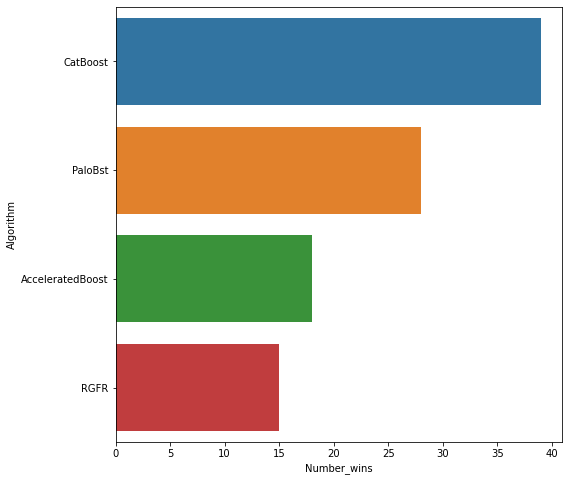

In [7]:
min_values=df_stat.min(axis=1)
result_dict={}
for index,row in df_stat.iterrows():
    data_name=row['Dataset name'].split('.')[0]
    data_name=data_name.replace('-',"_")
    if data_name=='Bike Sharing in Washington_kaggle':
        data_name='Bike_Sharing_in_Washington_kaggle'
        
    if row['AcceleratedBoost']==min_values[index]:
        result_dict[data_name]='AcceleratedBoost'
    elif row['CatBoost']==min_values[index]:
        result_dict[data_name]='CatBoost'
    elif row['PaloBst']==min_values[index]:
        result_dict[data_name]='PaloBst'
    elif row['RGFR']==min_values[index]:
        result_dict[data_name]='RGFR' 

c = collections.Counter(list(result_dict.values()))
number_wins=pd.DataFrame([(a,b) for a,b in c.items()])
number_wins.columns=['Algorithm','Number_wins']
number_wins=number_wins.sort_values(by='Number_wins',ascending=False)
display(number_wins)

fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(y='Algorithm', x='Number_wins',orient="h", data=number_wins, ax=ax)

#### Investigate time

Average training time


Algorithm  Training time
2           PaloBst     422.754634
1          CatBoost     267.777875
3              RGFR     178.179608
0  AcceleratedBoost      34.815685

Average infer time


Algorithm  Inference time
2           PaloBst        1.630968
3              RGFR        1.356760
0  AcceleratedBoost        0.818953
1          CatBoost        0.132337

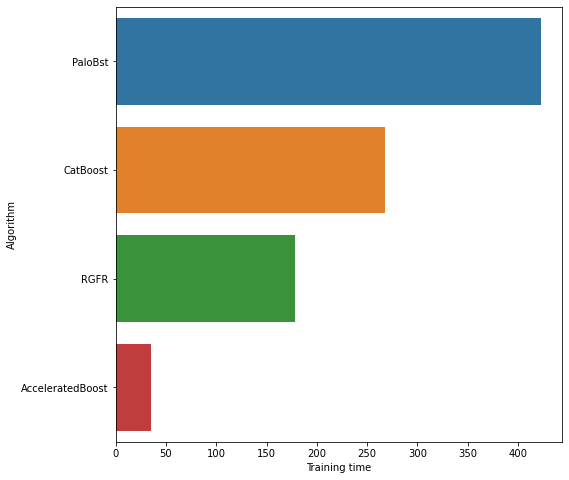

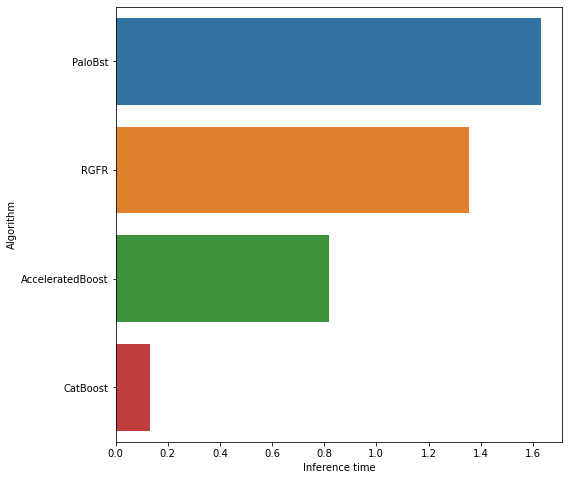

In [23]:
df_final
df_time_tr=df_final.groupby(['Algorithm'])['Training time'].mean().reset_index().sort_values(by='Training time',ascending=False)
df_time_inf=df_final.groupby(['Algorithm'])['Inference time'].mean().reset_index().sort_values(by='Inference time',ascending=False)
print('Average training time')
display(df_time_tr)
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(y='Algorithm', x='Training time',orient="h", data=df_time_tr, ax=ax)

print('Average infer time')
display(df_time_inf)
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(y='Algorithm', x='Inference time',orient="h", data=df_time_inf, ax=ax)

#### Now we apply test Friedman to see if the difference significant or not

P-value =1.6015882466091193e-05
H0 is reject
Provide Post Hoc Test


AcceleratedBoost  CatBoost   PaloBst      RGFR
AcceleratedBoost         -1.000000  0.900000  0.198718  0.001000
CatBoost                  0.900000 -1.000000  0.049306  0.001000
PaloBst                   0.198718  0.049306 -1.000000  0.220908
RGFR                      0.001000  0.001000  0.220908 -1.000000

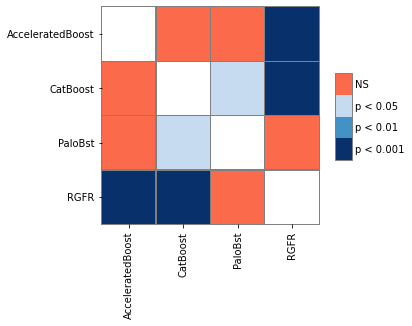

In [8]:
def test_statistic(df,labels,sign_level=0.05):
    data=df[labels].to_numpy()
    p_value=scipy.stats.friedmanchisquare(*data.T)[1]
    if p_value<sign_level:
        print('P-value ={}\nH0 is reject\nProvide Post Hoc Test'.format(p_value))       
        post_hoc=sp.posthoc_nemenyi_friedman(data)
        post_hoc.columns=labels
        post_hoc.index=labels
        display(post_hoc)       
        
        cmap = ['1', '#fb6a4a',  '#08306b',  '#4292c6', '#c6dbef']
        heatmap_args = {'cmap': cmap, 'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
        sp.sign_plot(post_hoc, **heatmap_args)
    else:
        print('P-value ={}\nH0 is not reject/n'.format(p_value))
        
test_statistic(df_stat,labels=['AcceleratedBoost','CatBoost','PaloBst','RGFR'])
       

### Meta learner

In [9]:
def label_encoder(df):
    cat_mask =df.dtypes == object
    cat_features=df.columns[cat_mask].tolist()
    for feature in cat_features:
        dict_map={}
        values=df[feature].unique()
        z=0
        for i in values:
            dict_map[i]=z
            z+=1
        df[feature]=df[feature].map(dict_map) 
    return df 

meta_df=pd.read_csv('meta/RegressionAll.csv')
meta_df['Alghorithm_name']=[['AcceleratedBoost','CatBoost','PaloBst','RGFR']]*meta_df.shape[0]
meta_df=meta_df.explode('Alghorithm_name')
meta_df['Result']=meta_df.apply(lambda x:1 if x['Alghorithm_name']==result_dict[x['name']] else 0,axis=1)
meta_df.to_csv('results/table_for_meta.csv',index=False)
meta_df.to_excel('results/table_for_meta.xlsx',index=False)
meta_df=label_encoder(meta_df)
meta_df.head(5)

name        f1        f2        f3        f4        f5        f6        f7  \
0     0 -0.027520  0.933713  0.973111 -0.768208  0.776167 -0.458172  0.857047   
0     0 -0.027520  0.933713  0.973111 -0.768208  0.776167 -0.458172  0.857047   
0     0 -0.027520  0.933713  0.973111 -0.768208  0.776167 -0.458172  0.857047   
0     0 -0.027520  0.933713  0.973111 -0.768208  0.776167 -0.458172  0.857047   
1     1  0.568194  0.941249  0.992854  0.099879  0.787352  0.402872  0.893484   

         f8        f9  ...  ratio_of_discrete_features  \
0  0.463357 -0.663956  ...                           0   
0  0.463357 -0.663956  ...                           0   
0  0.463357 -0.663956  ...                           0   
0  0.463357 -0.663956  ...                           0   
1  0.702854  0.227795  ...                           0   

   ratio_of_numeric_features  nonzero_vals_cnt  missing values  \
0                          1               156               0   
0                          1               156               0   
0                          1               156               0   
0                          1               156               0   
1                          1              3200               0   

   non-zero values  attributes total  attributes categorical  \
0              NaN                 4                       0   
0              NaN                 4                       0   
0              NaN                 4                       0   
0              NaN                 4                       0   
1              NaN                 8                       0   

   attributes numerical  Alghorithm_name  Result  
0                     4                0       0  
0                     4                1       0  
0                     4                2       1  
0                     4                3       0  
1                     8                0       0  

[5 rows x 170 columns]

In [10]:
names=meta_df['name'].unique()
roc_auc=[]
accuracy=[]
               
for name in names:
#     _____train______
    X=meta_df.drop('Result',axis=1)
    y=meta_df['Result']
    X_test=meta_df[meta_df['name']==name]
    y_test=X_test['Result']
    X_test=X_test.drop('Result',axis=1)
#     ________test_________
    X_train=meta_df[meta_df['name']!=name]
    y_train=X_train['Result']
    X_train=X_train.drop('Result',axis=1)
#     _______model______
    model=xgb.XGBClassifier( )
    model.fit(X_train,y_train)
    y_pred_prob = model.predict_proba(X_test)[:,1]
    y_pred = model.predict(X_test)
    accuracy.append(accuracy_score(y_test, y_pred))
    roc_auc.append(roc_auc_score(y_test, y_pred_prob))
average_roc=np.mean(roc_auc)
average_acc=np.mean(accuracy)
print('ROC AUC: {}'.format(average_roc))
print('Accuracy: {}\n'.format(average_acc))
print('Model parametrs: {}'.format(model.get_params()))

ROC AUC: 0.6566666666666667
Accuracy: 0.7825

Model parametrs: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}


#### Feature importance

#### By weight

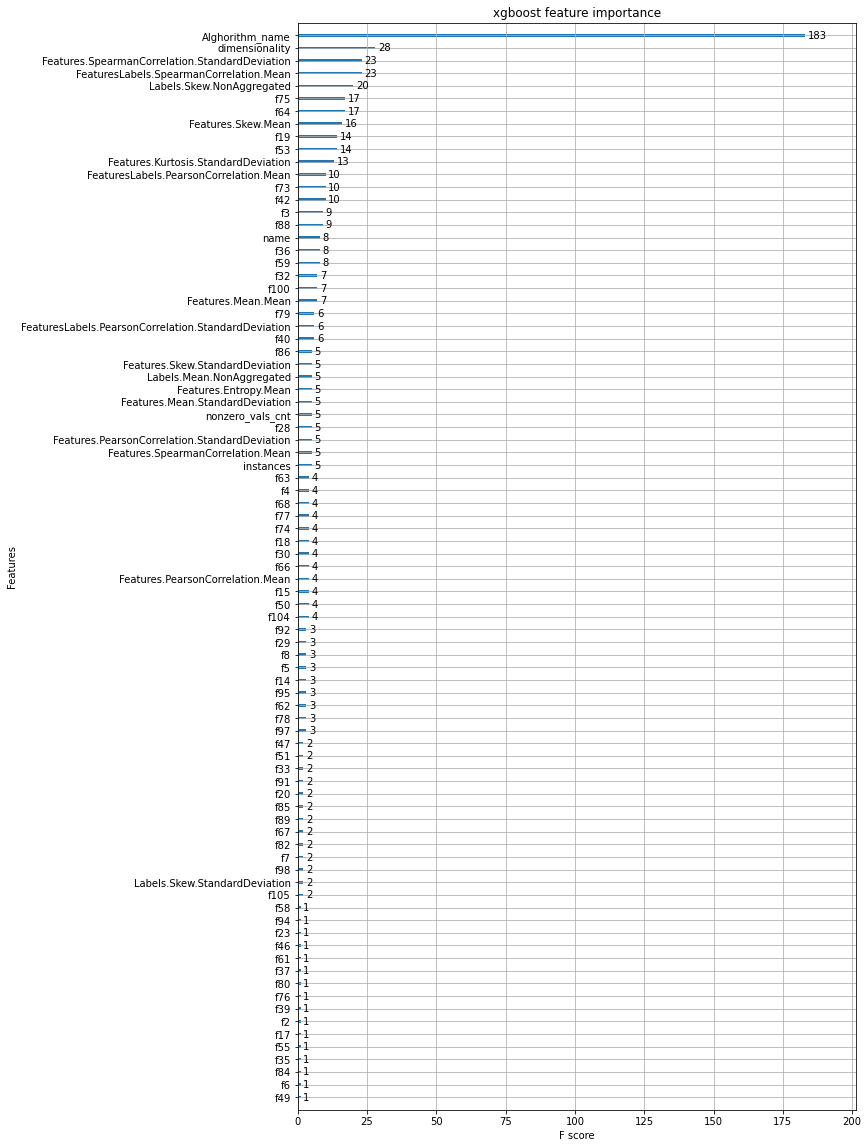

In [11]:
fig, ax = plt.subplots(1,1,figsize=(10,20))
xgb.plot_importance(model,ax=ax, importance_type='weight')
plt.title("xgboost feature importance")
plt.show()

#### By gain

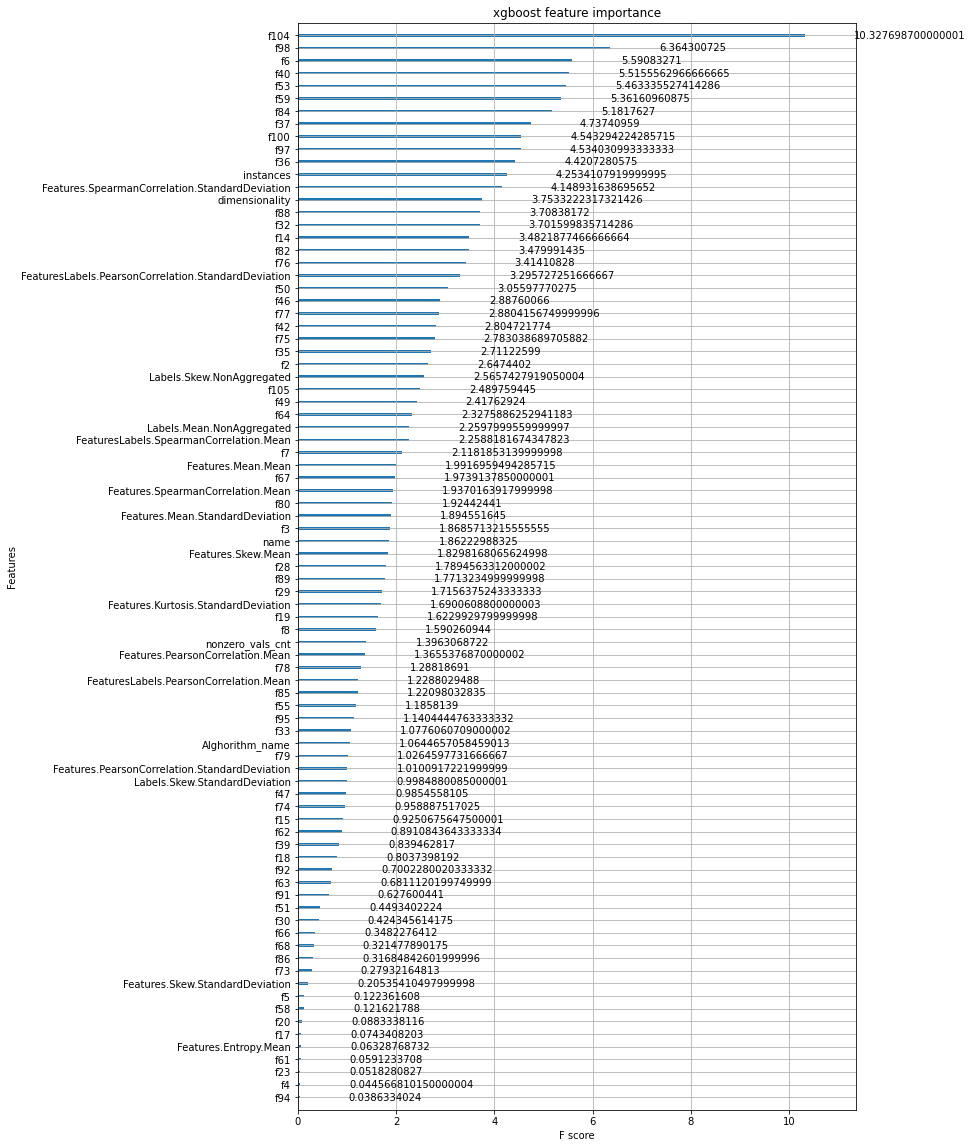

In [12]:
fig, ax = plt.subplots(1,1,figsize=(10,20))
xgb.plot_importance(model,ax=ax, importance_type='gain')
plt.title("xgboost feature importance")
plt.show()

#### By cover

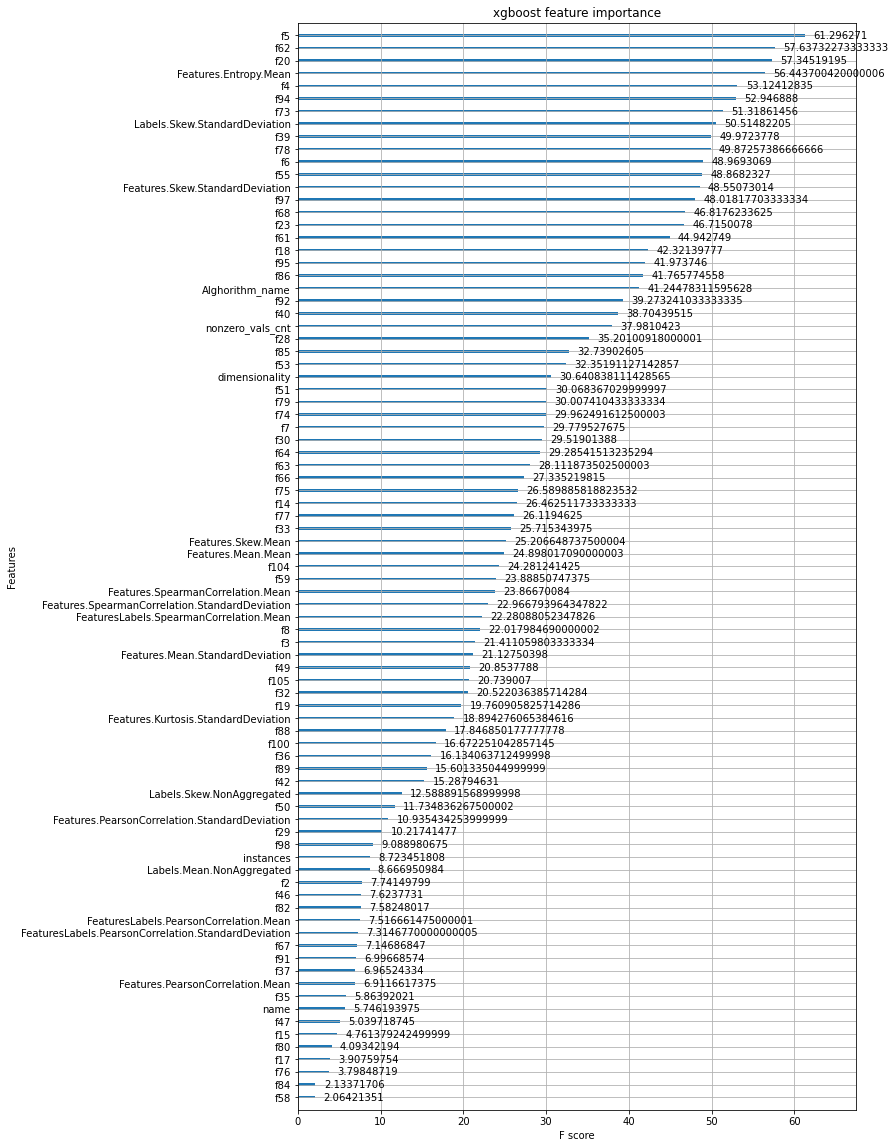

In [13]:
fig, ax = plt.subplots(1,1,figsize=(10,20))
xgb.plot_importance(model,ax=ax, importance_type='cover')
plt.title("xgboost feature importance")
plt.show()

#### SHAP

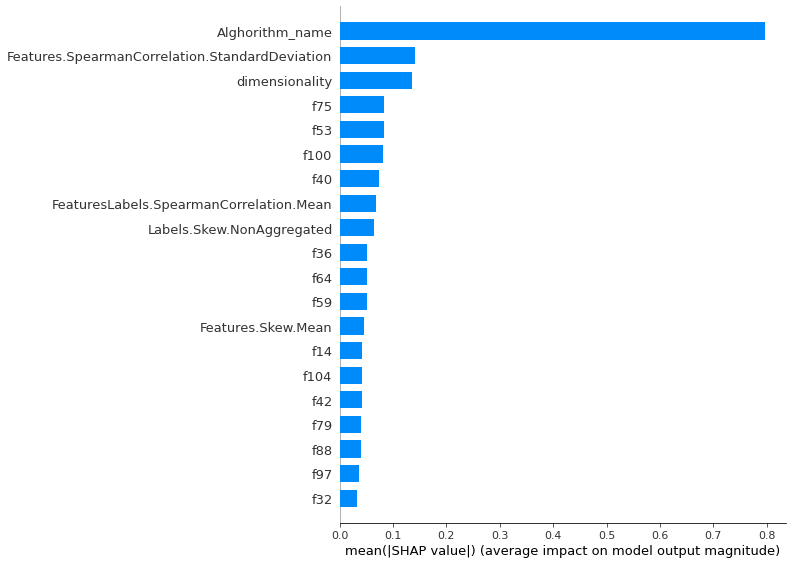

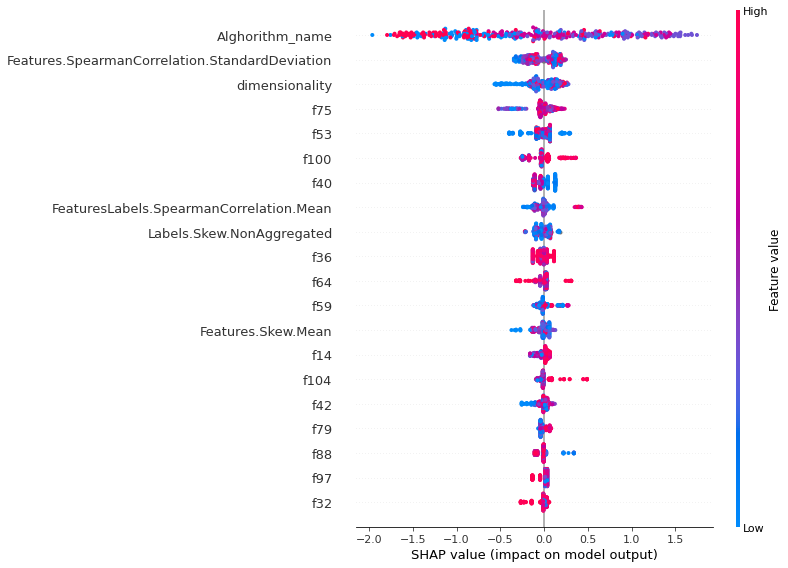

In [14]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X,plot_type="bar")
shap.summary_plot(shap_values, X)

#### Visualize a single prediction

In [15]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[37,:], X.iloc[[32],:])

#### Visualize many predictions

In [16]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X)